In [1]:
from skimage import img_as_ubyte
from osgeo import gdal, gdalconst
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append("../..")

from Utils.oneToOneMatch import oneToOneMatch
from Utils.oneToOneMatchSequential import oneToOneMatchSequential
from Utils.getPoints import pointsAsPixels, pointsAsPixels4326
from Utils.plotMacros import plotImageWithPointsSideBySide
from Utils.contourConfusionMatrixAndPerformance import contourConfusionMatrixAndPerformance

# ENSEMBLE VOTE

Several possible rules

Rules set 1: 
-   1 Vote: Discard
-   2 Vote: Human validation
-   3 or 4 Votes: Validated

Rules set 2:
-   1 or 2 Votes: Discard
-   3 Votes: Human validation
-   4 Votes: Validated

...

## Voting system

In [2]:
images_folder = os.path.join(sys.path[-1], "SNAP_Images")
true_shapefiles_folder = os.path.join(sys.path[-1], "Shapefiles")
predicted_shapefiles_folder = os.path.join(sys.path[-1], "Generated_Shapefiles")

train_images = ['06D2', '17F5', '264D', '84EF', 'D15B', 'E82B']
test_images = ['A890']
# '96C1', '2FCC'

images_names = train_images + test_images

In [3]:
def plot_votes(votes_coord, actual_x, actual_y, img, img_name):
    # Get max votes
    colors = {1: "g", 2: "b", 3: "r", 4: "r"}

    # Plot the votes and the true output side by side
    num_rows, num_cols = 1, 2
    im_size = 8

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*im_size, num_rows*im_size))
    axes = np.reshape(axes, (num_rows, num_cols))

    axes[0, 0].imshow(img, cmap="gray")
    for i in range(len(votes_coord)):
        votes_coord_i_x, votes_coord_i_y = votes_coord[i].T
        axes[0, 0].scatter(votes_coord_i_x, votes_coord_i_y, s=1, c=colors[i+1])
    axes[0, 0].set_title(f'{img_name} Votes 1 to 4 (red = 3+ votes, blue = 2 votes, green = 1 vote)')
    axes[0, 0].axis("off")

    axes[0, 1].imshow(img, cmap="gray")
    axes[0, 1].scatter(actual_x, actual_y, s=1, c="r")
    axes[0, 1].set_title(f'{img_name} True output')
    axes[0, 1].axis("off")

    plt.show()

In [4]:
import time

results = {}

for img_name in images_names:
    print(f"Processing {img_name}")

    # Get the img_name path
    filename = os.listdir(f"{images_folder}/{img_name}")[0]
    image_path = f"{images_folder}/{img_name}/{filename}"
    ds = gdal.Open(image_path, gdalconst.GA_ReadOnly)
    gt = ds.GetGeoTransform()
    img = np.asarray(ds.GetRasterBand(1).ReadAsArray())
    img = img_as_ubyte(img)

    # Get the true shapefile path
    folder_name = [folder for folder in os.listdir(f"{true_shapefiles_folder}") if folder[-4:]==img_name][0]
    true_shapefile_path = f"{true_shapefiles_folder}/{folder_name}/{folder_name}.shp"

    # Get the predicted shapefile path
    snap_shapefile_path = f"{predicted_shapefiles_folder}/SNAP_{img_name}/SNAP_{img_name}.shp"
    cnn_shapefile_path = f"{predicted_shapefiles_folder}/CNN_Nandi_shpfile/{img_name}/{img_name}.shp"
    resnet_shapefile_path = f"{predicted_shapefiles_folder}/results-Jiaxin/{img_name}/{img_name}.shp"

    print(f"{img_name}: Importing files")
    # Import all shapefiles, have a vote.
    # TODO: solve why we need 4326 for shapefiles from SNAP
    actual_x, actual_y = pointsAsPixels(true_shapefile_path, gt)
    snap_x, snap_y = pointsAsPixels4326(snap_shapefile_path, gt)  # need to use 4326 for SNAP
    cnn_x, cnn_y = pointsAsPixels(cnn_shapefile_path, gt)
    resn_x, resn_y = pointsAsPixels4326(resnet_shapefile_path, gt)

    print(f"{img_name}: Matching points...")
    snap_coord = np.array([snap_x, snap_y])
    cnn_coord = np.array([cnn_x, cnn_y])
    resn_coord = np.array([resn_x, resn_y])

    max_dist = 50
    start_time = time.time()
    votes = oneToOneMatchSequential([snap_coord, cnn_coord, resn_coord], max_dist)
    end_time = time.time()
    print(f"{img_name}: Matching points...DONE")
    print(f"{img_name}: Time taken {end_time-start_time}s")

    # Get coordinates for each vote value
    max_votes = max(votes.values())
    votes_nb = [list(filter(lambda x: x[1] == i, votes.items())) for i in range(1, max_votes+1)]
    votes_coord = [np.array([x[0] for x in votes_i]) for votes_i in votes_nb]

    # Plot the votes
    plot_votes(votes_coord, actual_x, actual_y, img, img_name)

    # Save the votes
    results[img_name] = votes

Processing 06D2
06D2: Importing files


AttributeError: 'NoneType' object has no attribute 'GetLayer'

In [ ]:
# Make dict with key as strings of tuples
results_str = {}
for img_name in results.keys():
    results_str[img_name] = {}
    for key in results[img_name].keys():
        results_str[img_name][str(key)] = results[img_name][key]

# Save the results as JSON
import json
with open('results_str.json', 'w') as fp:
    json.dump(results_str, fp)

In [ ]:
# Load the results
import re

def key_as_tuple(key_string):
    key_tuple = tuple([float(s) for s in re.findall(r'-?\d+\.?\d*', key_string)])
    return key_tuple

with open('results_str.json') as json_file:
    results_str_loaded = json.load(json_file)

# Make dict with key as tuples
results_loaded = {}
for img_name in results_str_loaded.keys():
    results_loaded[img_name] = {}
    for key in results_str_loaded[img_name].keys():
        results_loaded[img_name][key_as_tuple(key)] = results_str_loaded[img_name][key]

results = results_loaded

## Evaluate accuracy

In [ ]:
def get_and_print_evaluation_metrics(result, pred_array, actual_array, model_name):
    print(f"Model {model_name}")
    print(f"Number of matches: {len(result)}, Number of actual points: {len(actual_array)}")
    confusion_matrix, precision, recall, f1_score = contourConfusionMatrixAndPerformance(result, pred_array, actual_array)
    print("Confusion Matrix:\n", confusion_matrix, "\nPrecision:", precision, " Recall:", recall, " F1 Score:", f1_score)
    return confusion_matrix, precision, recall, f1_score


In [ ]:
import time

evaluation_metrics = {}

for img_name in images_names:
    # try:
    print(f"Processing {img_name}")
    evaluation_metrics[img_name] = {}

    # Get the img_name path
    filename = os.listdir(f"{images_folder}/{img_name}")[0]
    image_path = f"{images_folder}/{img_name}/{filename}"
    ds = gdal.Open(image_path, gdalconst.GA_ReadOnly)
    gt = ds.GetGeoTransform()

    # Get the true shapefile path
    folder_name = [folder for folder in os.listdir(f"{true_shapefiles_folder}") if folder[-4:]==img_name][0]
    true_shapefile_path = f"{true_shapefiles_folder}/{folder_name}/{folder_name}.shp"

    # Get the predicted shapefile path
    snap_shapefile_path = f"{predicted_shapefiles_folder}/SNAP_{img_name}/SNAP_{img_name}.shp"
    cnn_shapefile_path = f"{predicted_shapefiles_folder}/CNN_Nandi_shpfile/{img_name}/{img_name}.shp"
    resnet_shapefile_path = f"{predicted_shapefiles_folder}/results-Jiaxin/{img_name}/{img_name}.shp"

    # Get coordinates for each model
    actual_x, actual_y = pointsAsPixels(true_shapefile_path, gt)
    snap_x, snap_y = pointsAsPixels4326(snap_shapefile_path, gt)  # need to use 4326 for SNAP
    cnn_x, cnn_y = pointsAsPixels(cnn_shapefile_path, gt)
    resn_x, resn_y = pointsAsPixels4326(resnet_shapefile_path, gt)  # need to use 4326 for SNAP

    # Compute evaluation metric for each model and ensemble model
    snap_coord = np.array([snap_x, snap_y])
    cnn_coord = np.array([cnn_x, cnn_y])
    resn_coord = np.array([resn_x, resn_y])

    max_dist = 50
    # SNAP
    result, pred_array, actual_array = oneToOneMatch(snap_coord, np.array([actual_x, actual_y]), max_dist)
    # Save the arrays in folder "SNAP_matched_arrays". If folder doesn't exist, create it
    np.save(f"SNAP_matched_arrays/{img_name}_pred_array.npy", pred_array)
    np.save(f"SNAP_matched_arrays/{img_name}_actual_array.npy", actual_array)
    np.save(f"SNAP_matched_arrays/{img_name}_result.npy", result)
    confusion_matrix, precision, recall, f1_score = get_and_print_evaluation_metrics(result, pred_array, actual_array, "SNAP")
    evaluation_metrics[img_name]["SNAP"] = {"confusion_matrix": confusion_matrix, "precision": precision, "recall": recall, "f1_score": f1_score}
    
    # CNN
    result, pred_array, actual_array = oneToOneMatch(cnn_coord, np.array([actual_x, actual_y]), max_dist)
    np.save(f"CNN_matched_arrays/{img_name}_pred_array.npy", pred_array)
    np.save(f"CNN_matched_arrays/{img_name}_actual_array.npy", actual_array)
    np.save(f"CNN_matched_arrays/{img_name}_result.npy", result)
    confusion_matrix, precision, recall, f1_score = get_and_print_evaluation_metrics(result, pred_array, actual_array, "CNN")
    evaluation_metrics[img_name]["CNN"] = {"confusion_matrix": confusion_matrix, "precision": precision, "recall": recall, "f1_score": f1_score}

    # ResNet
    result, pred_array, actual_array = oneToOneMatch(resn_coord, np.array([actual_x, actual_y]), max_dist)
    np.save(f"ResNet_matched_arrays/{img_name}_pred_array.npy", pred_array)
    np.save(f"ResNet_matched_arrays/{img_name}_actual_array.npy", actual_array)
    np.save(f"ResNet_matched_arrays/{img_name}_result.npy", result)
    confusion_matrix, precision, recall, f1_score = get_and_print_evaluation_metrics(result, pred_array, actual_array, "ResNet")
    evaluation_metrics[img_name]["ResNet"] = {"confusion_matrix": confusion_matrix, "precision": precision, "recall": recall, "f1_score": f1_score}

    # For ensemble model, only consider votes 2 to 4
    votes_nb = [list(filter(lambda x: x[1] == i, results[img_name].items())) for i in range(1, 4)]
    votes_coord = [np.array([x[0] for x in votes_i]) for votes_i in votes_nb]
    votes_2_to_3 = np.concatenate(votes_coord[1:], axis=0)
    result, pred_array, actual_array = oneToOneMatch(votes_2_to_3.T, np.array([actual_x, actual_y]), max_dist)
    np.save(f"Ensemble_matched_arrays/{img_name}_pred_array.npy", pred_array)
    np.save(f"Ensemble_matched_arrays/{img_name}_actual_array.npy", actual_array)
    np.save(f"Ensemble_matched_arrays/{img_name}_result.npy", result)
    confusion_matrix, precision, recall, f1_score = get_and_print_evaluation_metrics(result, pred_array, actual_array, "Ensemble")
    evaluation_metrics[img_name]["Ensemble"] = {"confusion_matrix": confusion_matrix, "precision": precision, "recall": recall, "f1_score": f1_score}
        
    # except Exception as e:
    #     print(f"Error processing {img_name}")
    #     print(e)
    #     continue

Processing 06D2
Model SNAP
Number of matches: 18, Number of actual points: 21
Confusion Matrix:
 [[18. 16.]
 [ 3.  0.]] 
Precision: 0.5294117647058824  Recall: 0.8571428571428571  F1 Score: 0.6545454545454545
Model CNN
Number of matches: 13, Number of actual points: 21
Confusion Matrix:
 [[ 13. 470.]
 [  8.   0.]] 
Precision: 0.026915113871635612  Recall: 0.6190476190476191  F1 Score: 0.05158730158730159
Model ResNet
Number of matches: 14, Number of actual points: 21
Confusion Matrix:
 [[  14. 1229.]
 [   7.    0.]] 
Precision: 0.011263073209975865  Recall: 0.6666666666666666  F1 Score: 0.022151898734177215
Model Ensemble
Number of matches: 15, Number of actual points: 21
Confusion Matrix:
 [[ 15. 267.]
 [  6.   0.]] 
Precision: 0.05319148936170213  Recall: 0.7142857142857143  F1 Score: 0.099009900990099
Processing 17F5
Model SNAP
Number of matches: 4663, Number of actual points: 6661
Confusion Matrix:
 [[4663.  281.]
 [1998.    0.]] 
Precision: 0.9431634304207119  Recall: 0.7000450382

In [ ]:
# Save evaluation metrics as JSON
evaluation_metrics_with_arr = {}

for key in evaluation_metrics.keys():
    evaluation_metrics_with_arr[key] = {}
    for model in evaluation_metrics[key].keys():
        evaluation_metrics_with_arr[key][model] = {}
        evaluation_metrics_with_arr[key][model]["confusion_matrix"] = [(int(x[0]), int(x[1])) for x in evaluation_metrics[key][model]["confusion_matrix"]]
        evaluation_metrics_with_arr[key][model]["precision"] = evaluation_metrics[key][model]["precision"]
        evaluation_metrics_with_arr[key][model]["recall"] = evaluation_metrics[key][model]["recall"]
        evaluation_metrics_with_arr[key][model]["f1_score"] = evaluation_metrics[key][model]["f1_score"]

# Save the evaluation metrics as JSON
with open('evaluation_metrics_with_arr.json', 'w') as fp:
    json.dump(evaluation_metrics_with_arr, fp)

In [ ]:
# Load the evaluation metrics
with open('evaluation_metrics_with_arr.json') as json_file:
    evaluation_metrics_with_arr = json.load(json_file)

# Study results

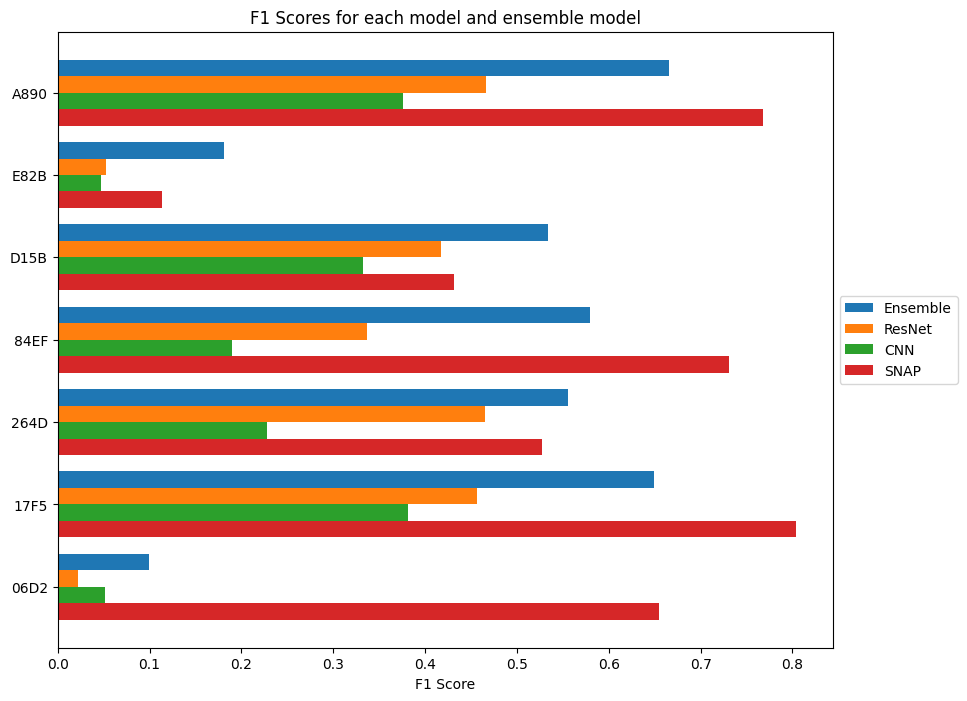

<Figure size 640x480 with 0 Axes>

In [ ]:
f1_scores = [[evaluation_metrics_with_arr[img_name][model]["f1_score"] for model in evaluation_metrics_with_arr['A890'].keys()] for img_name in images_names]
f1_scores = np.array(f1_scores)

# Create a horizontal bar graph with grouped bars
fig, ax = plt.subplots(figsize=(10, 8))

# Set the position for each group of bars
bar_width = 0.2
index = np.arange(len(images_names))

# Plot the bars for each name
model_names = ["SNAP", "CNN", "ResNet", "Ensemble"]
for i in range(1-len(f1_scores[0]),1):
    bars = ax.barh(index - i * bar_width, f1_scores[:, -i], bar_width, label=model_names[-i])

# Set the y-axis labels and ticks
ax.set_yticks(index + (len(f1_scores[0]) - 1) * bar_width / 2)
ax.set_yticklabels(images_names)

# Add labels and legend
ax.set_xlabel('F1 Score')
ax.set_title('F1 Scores for each model and ensemble model')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside to the right

# Show the plot
plt.show()

# Save the image
plt.savefig("study_images/f1_score_vs_model.png")


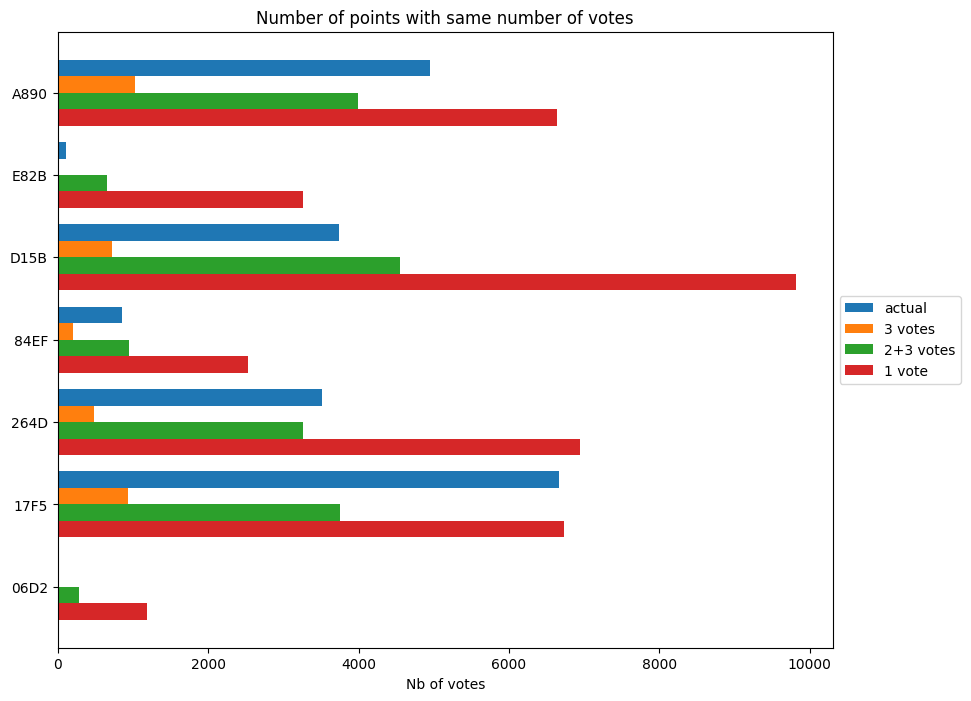

In [ ]:
nb_votes = []
for img_name in images_names:
    # Get gt
    filename = os.listdir(f"{images_folder}/{img_name}")[0]
    image_path = f"{images_folder}/{img_name}/{filename}"
    ds = gdal.Open(image_path, gdalconst.GA_ReadOnly)
    gt = ds.GetGeoTransform()

    nb_votes_img = [len(list(filter(lambda x: x[1] == i, results[img_name].items()))) for i in range(1, 4)]
    nb_votes_img = [nb_votes_img[0]] + [sum(nb_votes_img[1:])] + [nb_votes_img[2]]

    # Get the true shapefile path
    folder_name = [folder for folder in os.listdir(f"{true_shapefiles_folder}") if folder[-4:]==img_name][0]
    true_shapefile_path = f"{true_shapefiles_folder}/{folder_name}/{folder_name}.shp"
    actual_x, actual_y = pointsAsPixels(true_shapefile_path, gt)

    # Record actual number of points
    nb_votes.append(nb_votes_img + [len(actual_x)])

# Sum together second and third element of each row (we consider votes 2 to 3)


nb_votes = np.array(nb_votes)

# Create a horizontal bar graph with grouped bars
fig, ax = plt.subplots(figsize=(10, 8))

# Set the position for each group of bars
bar_width = 0.2
index = np.arange(len(images_names))

# Plot the bars for each name
votes_labels = ["1 vote", "2+3 votes", "3 votes", "actual"]
for i in range(1-len(nb_votes[0]),1):
    bars = ax.barh(index - i * bar_width, nb_votes[:, -i], bar_width, label=votes_labels[-i])

# Set the y-axis labels and ticks
ax.set_yticks(index + (len(nb_votes[0]) - 1) * bar_width / 2)
ax.set_yticklabels(images_names)

# Add labels and legend
ax.set_xlabel('Nb of votes')
ax.set_title('Number of points with same number of votes')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside to the right

# Show the plot
plt.show()

# Save the image
plt.savefig("study_images/nb_points_vs_votes.png")

## Plot all images

Processing 06D2
06D2: Importing files


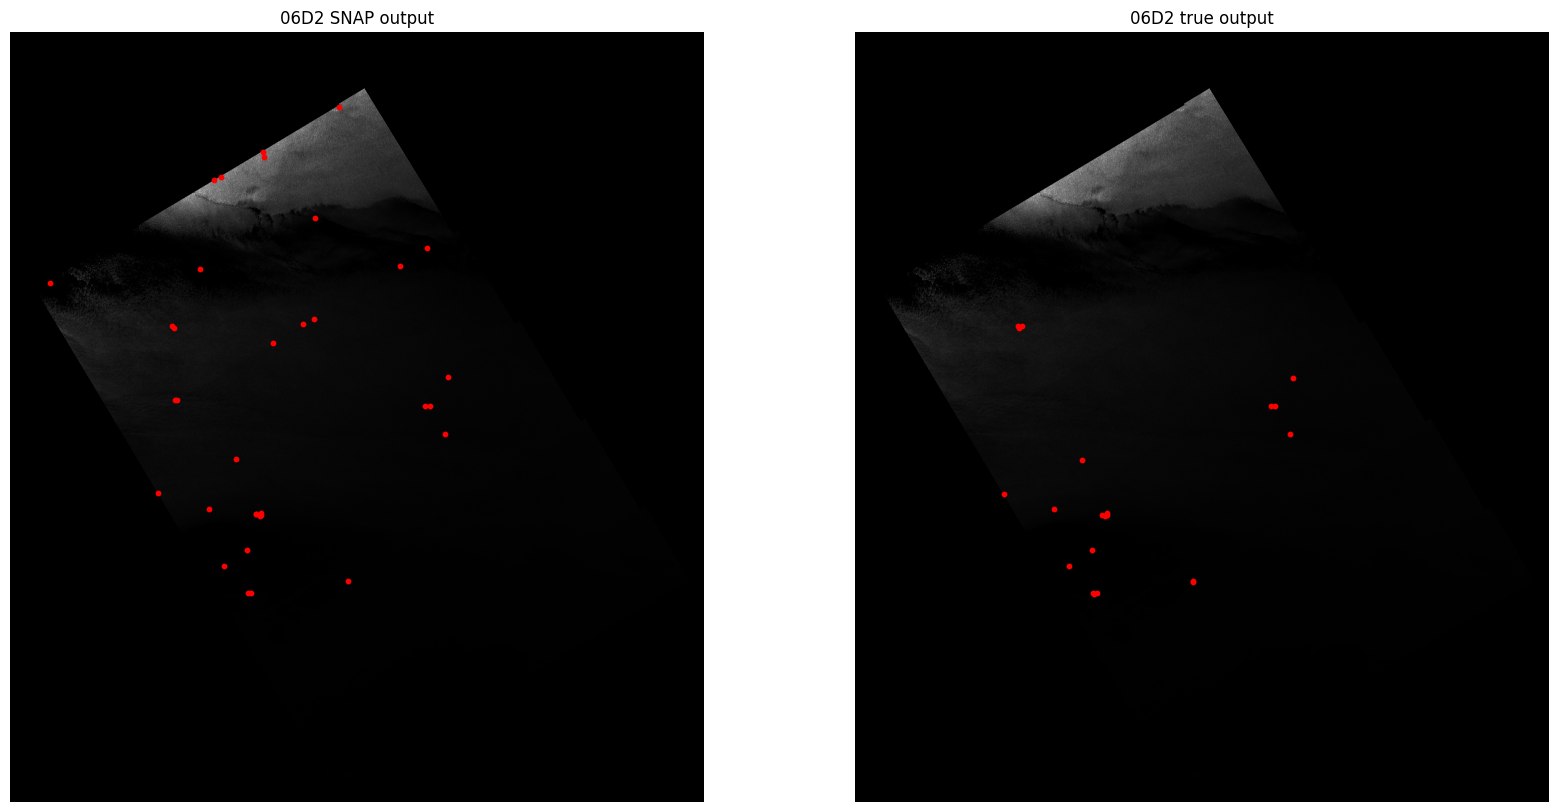

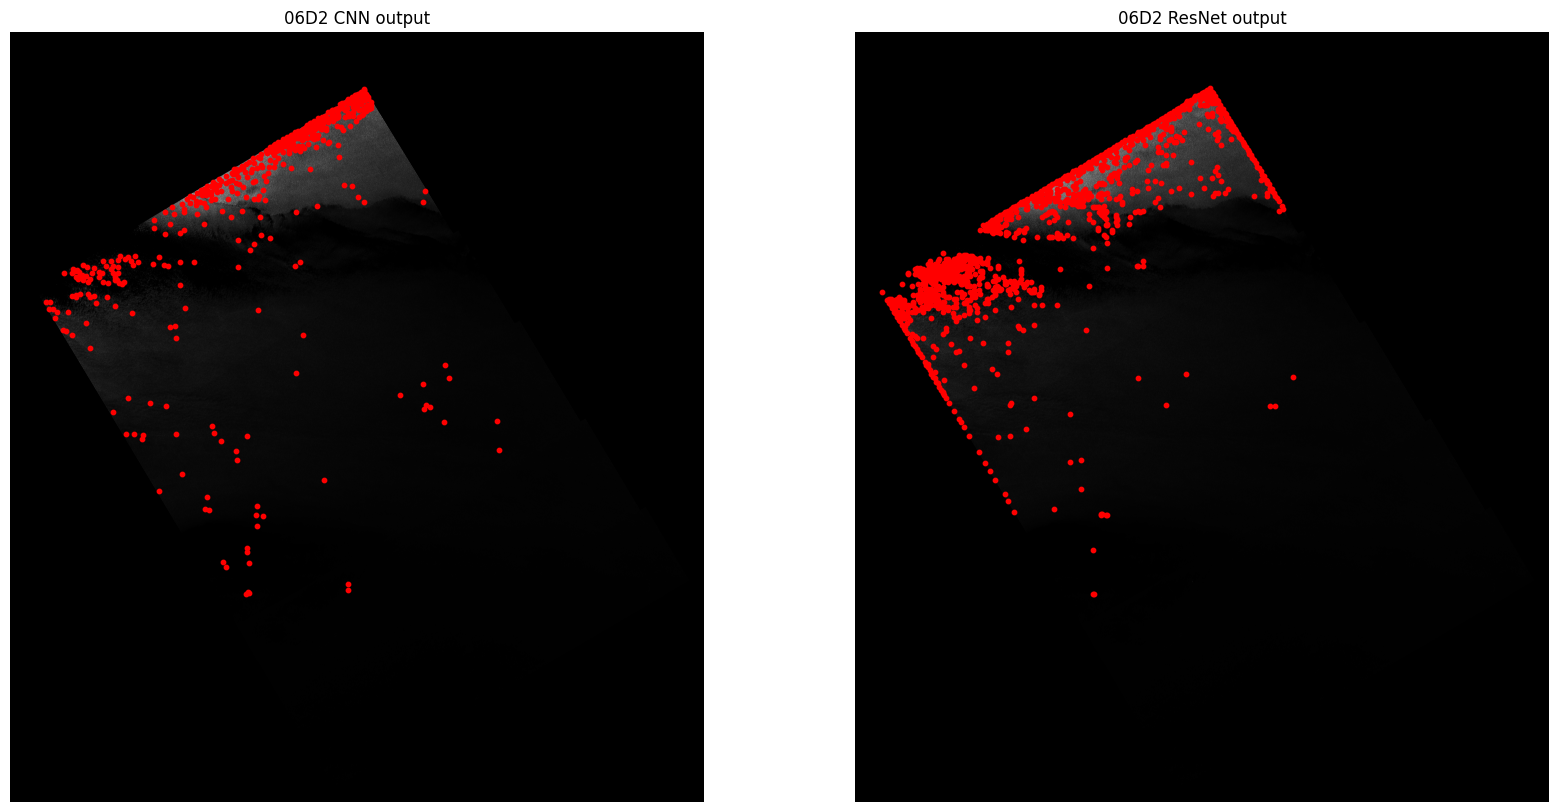

Processing 17F5
17F5: Importing files


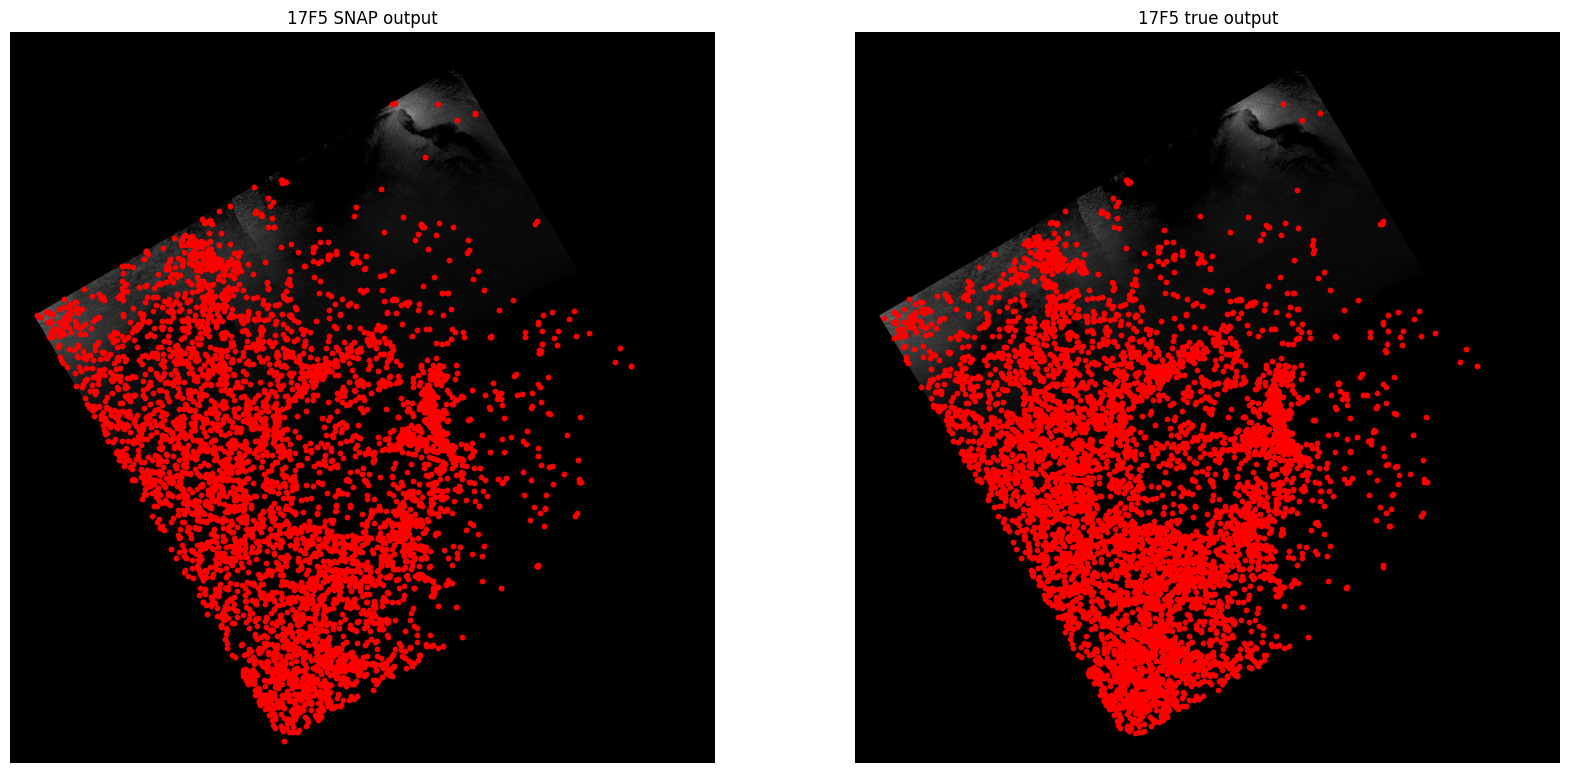

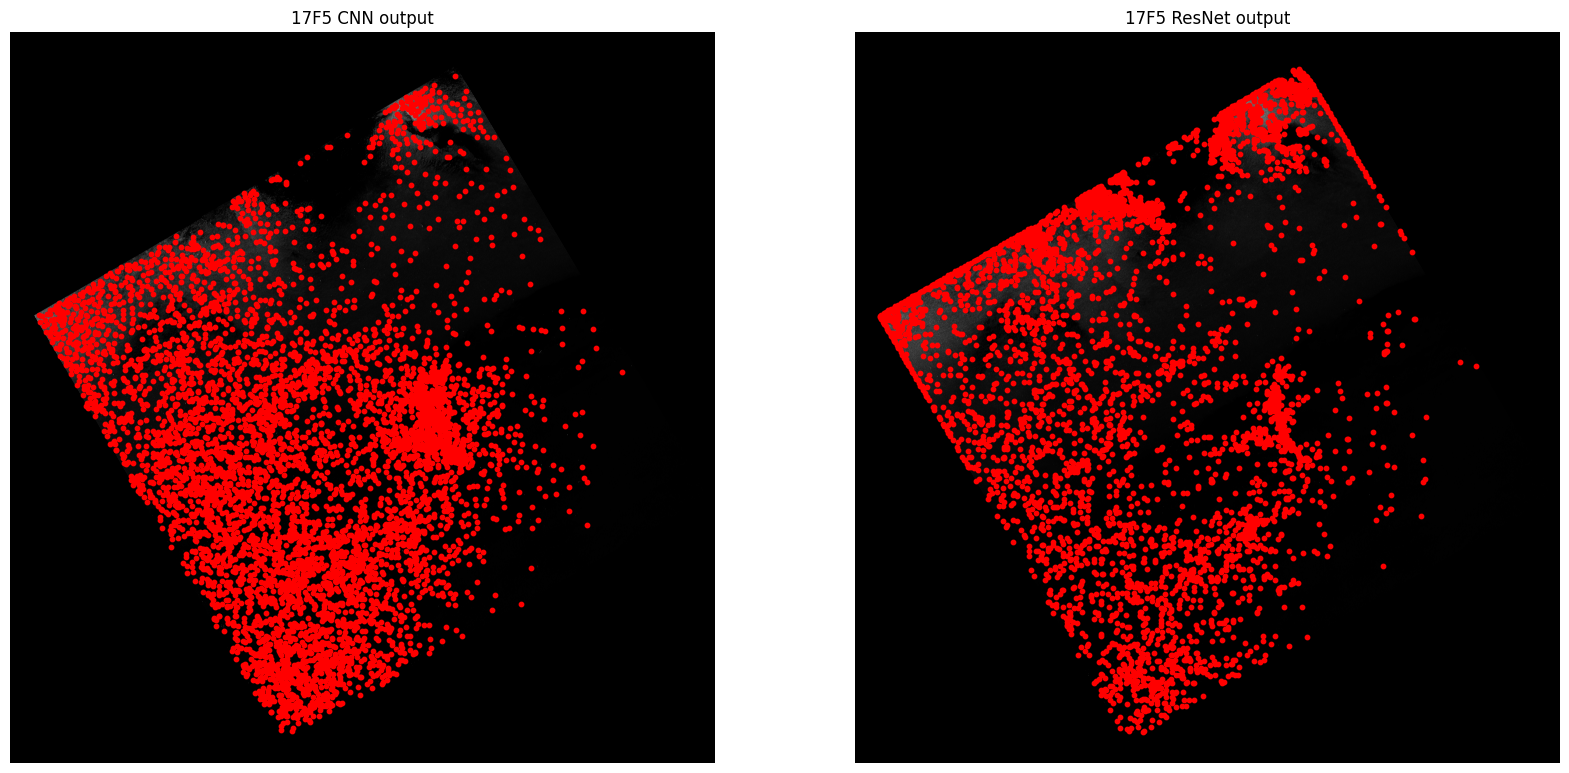

Processing 264D
264D: Importing files


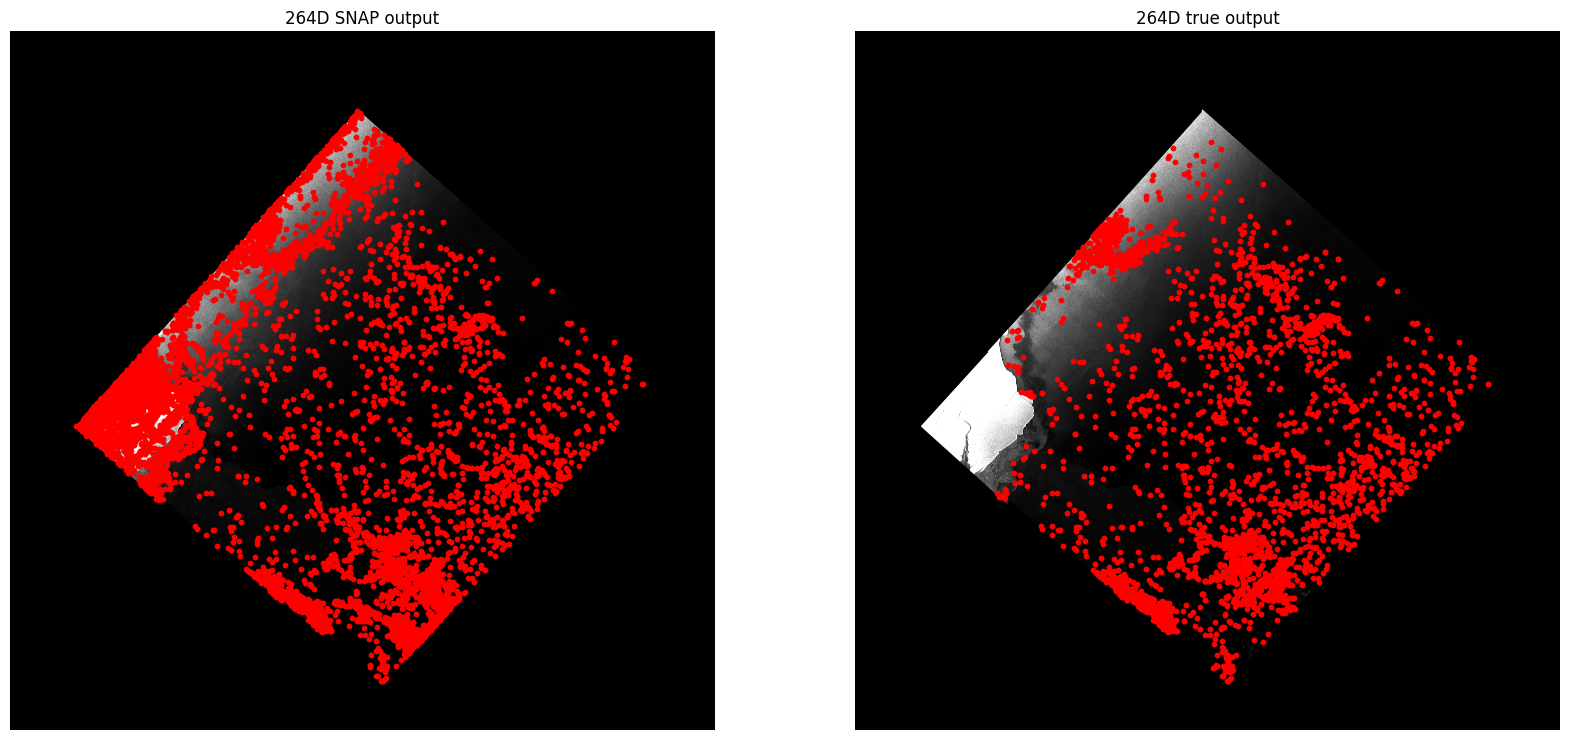

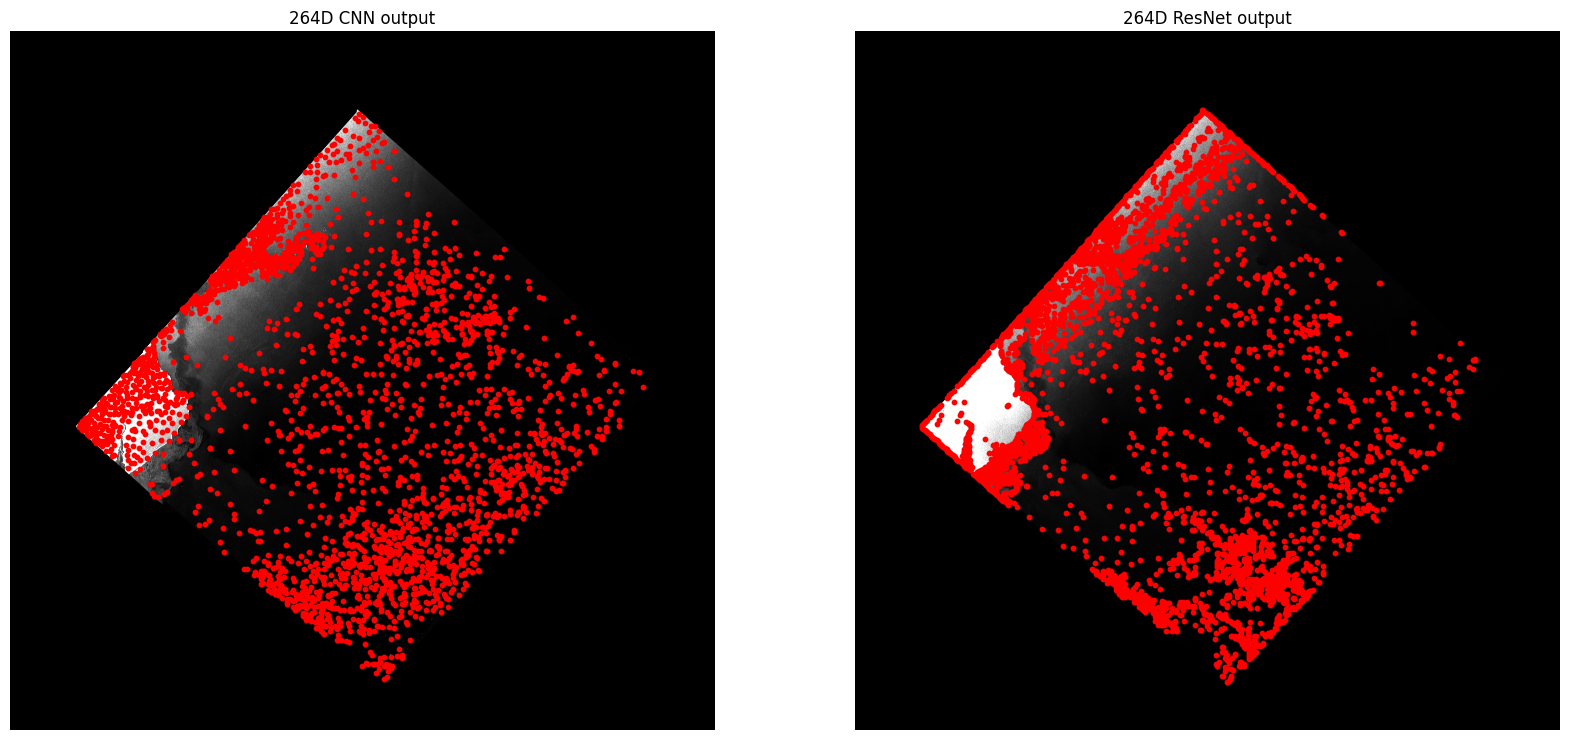

Processing 84EF
84EF: Importing files


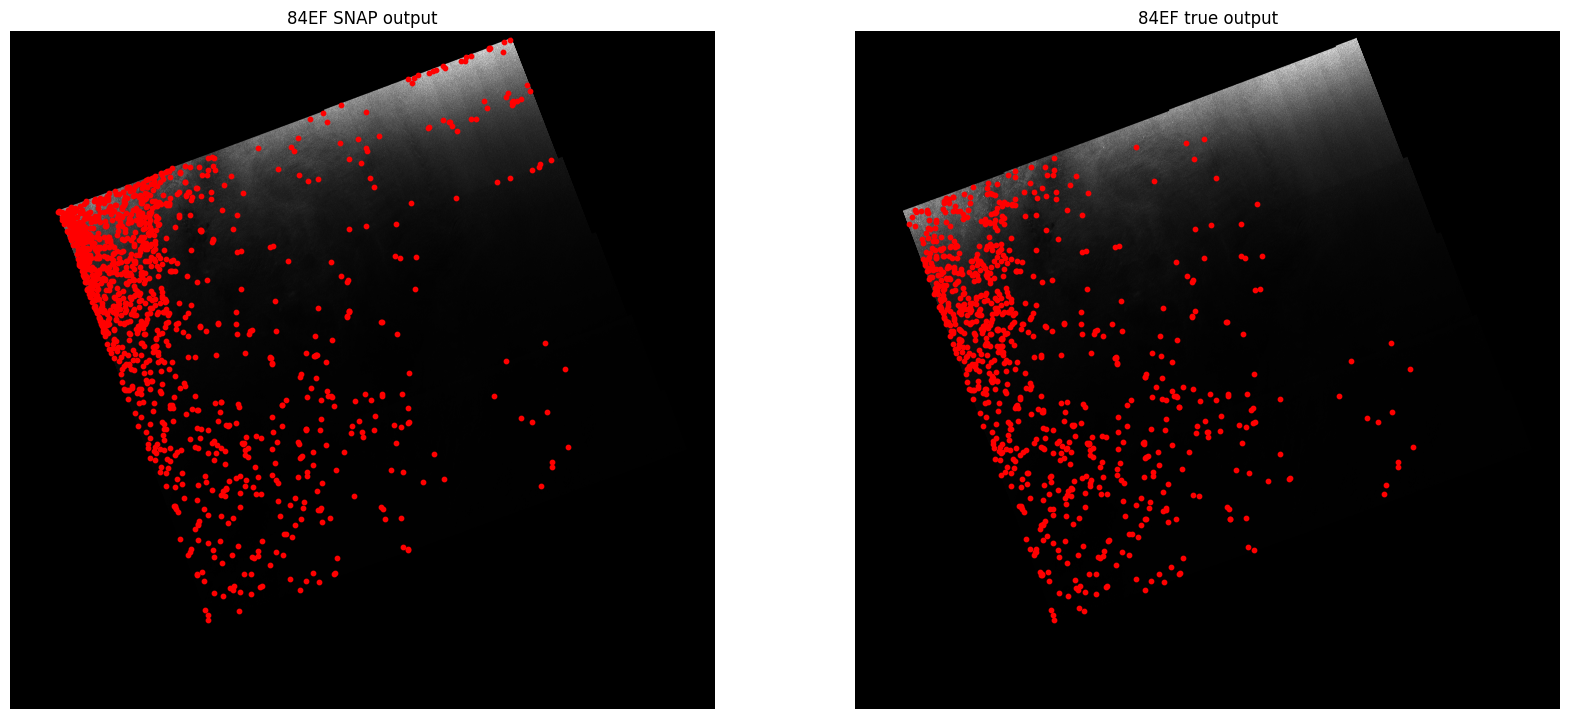

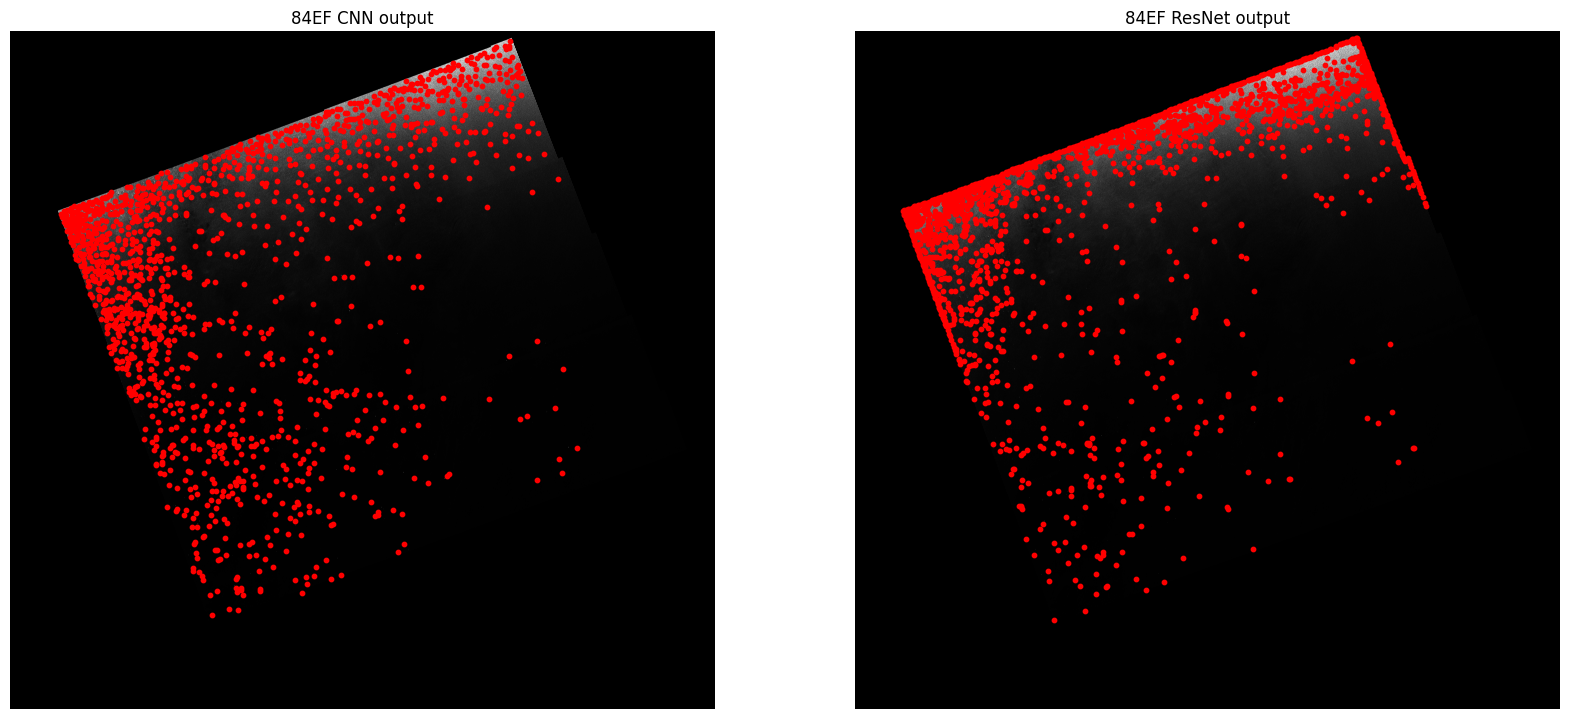

Processing D15B
D15B: Importing files


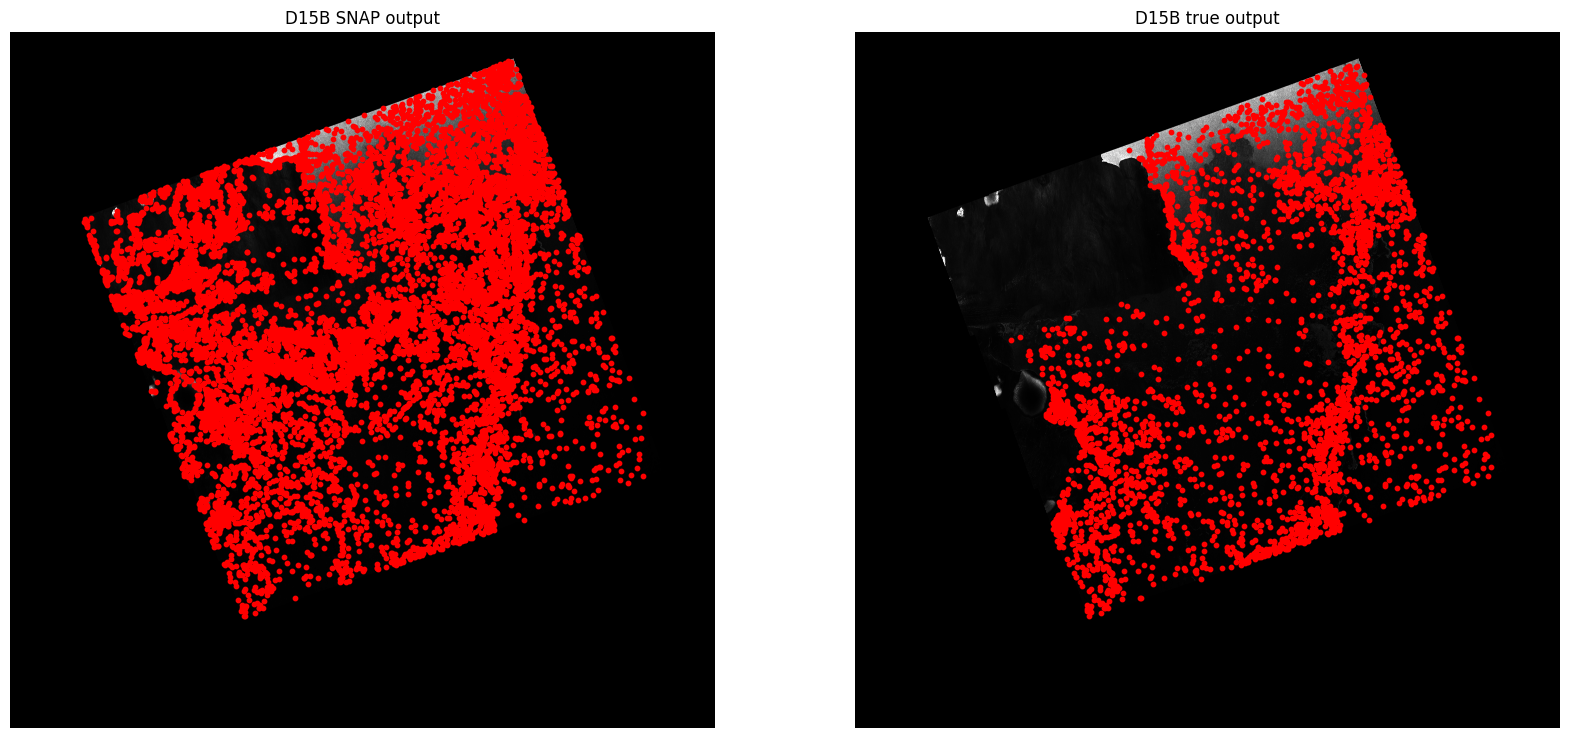

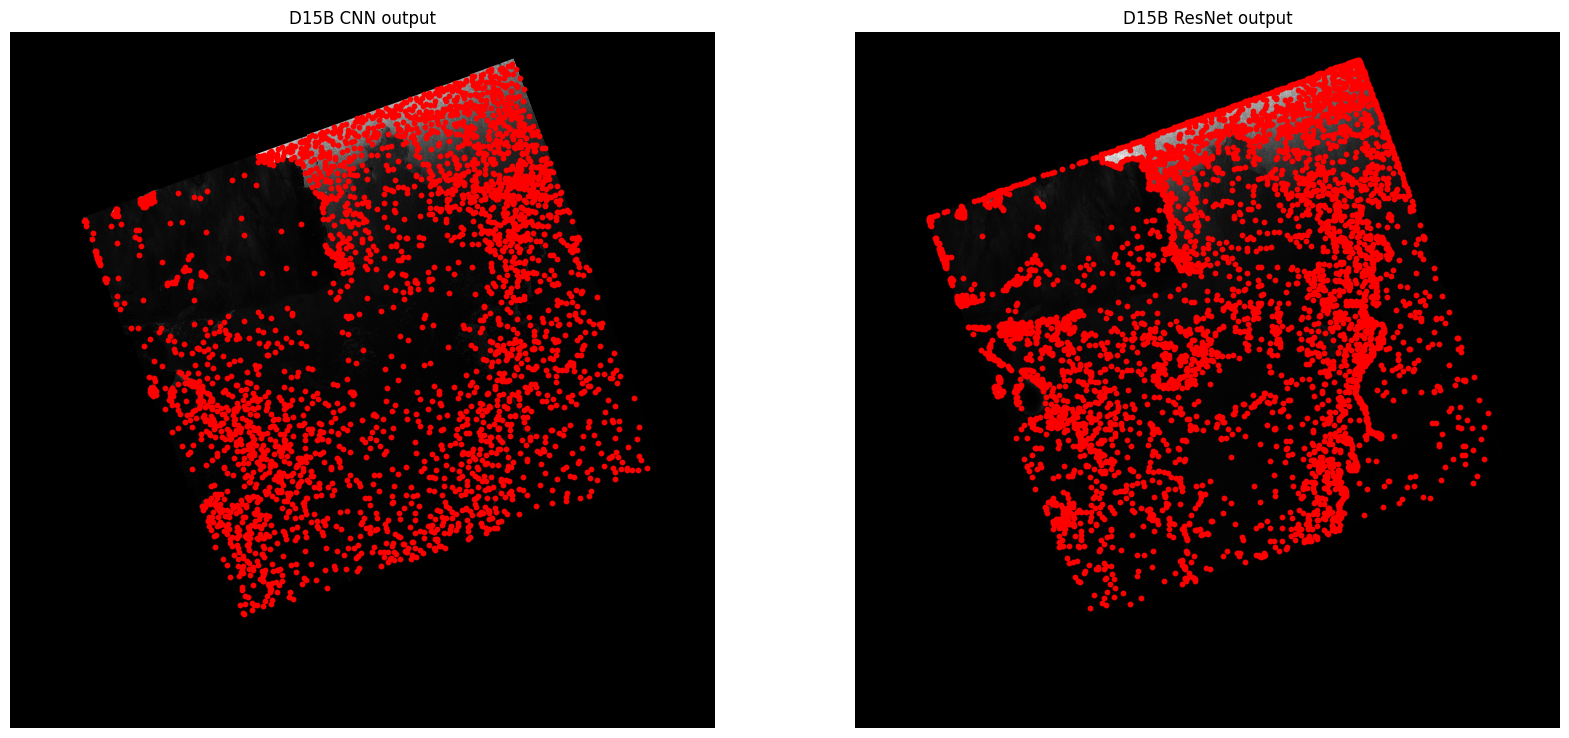

Processing E82B
E82B: Importing files


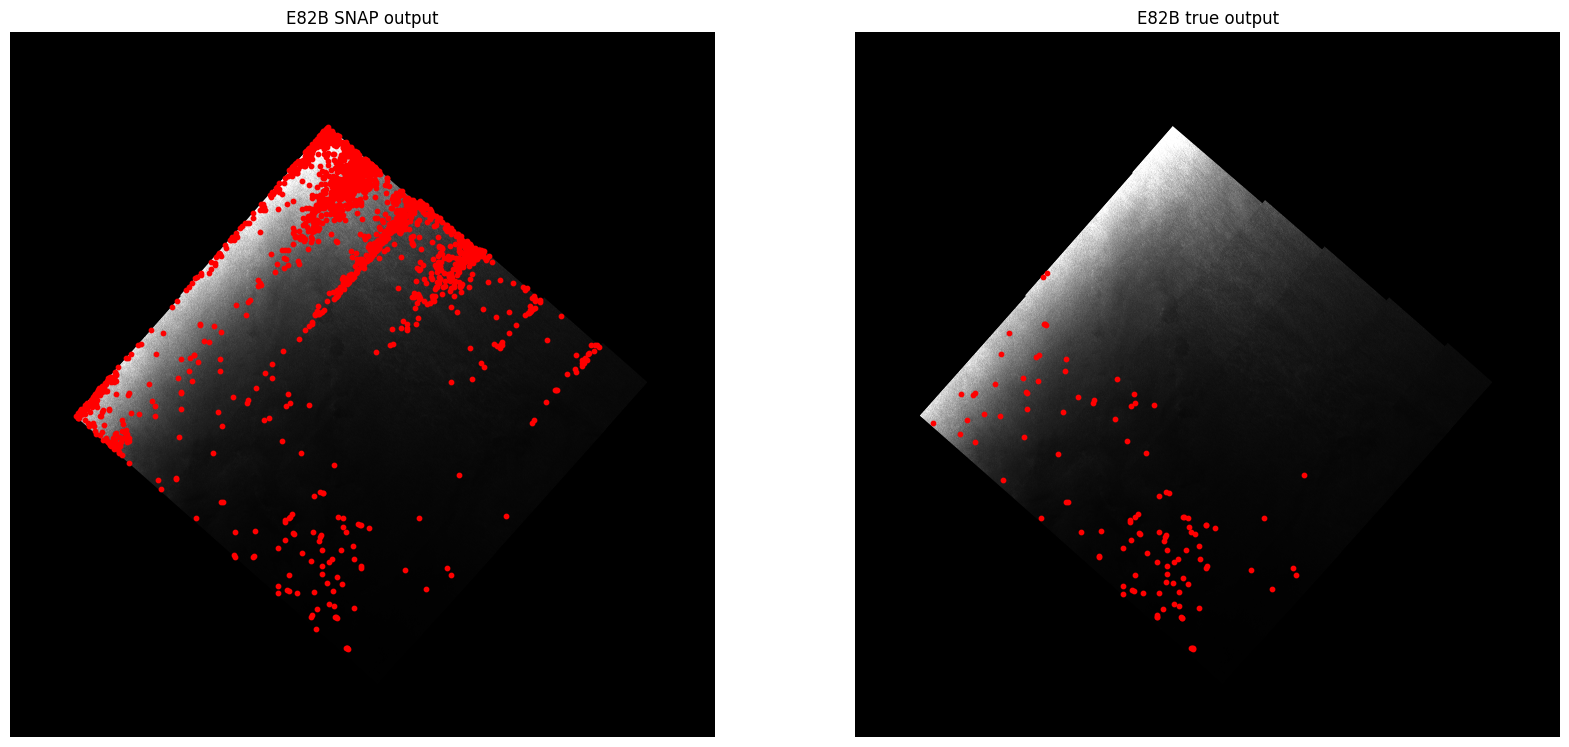

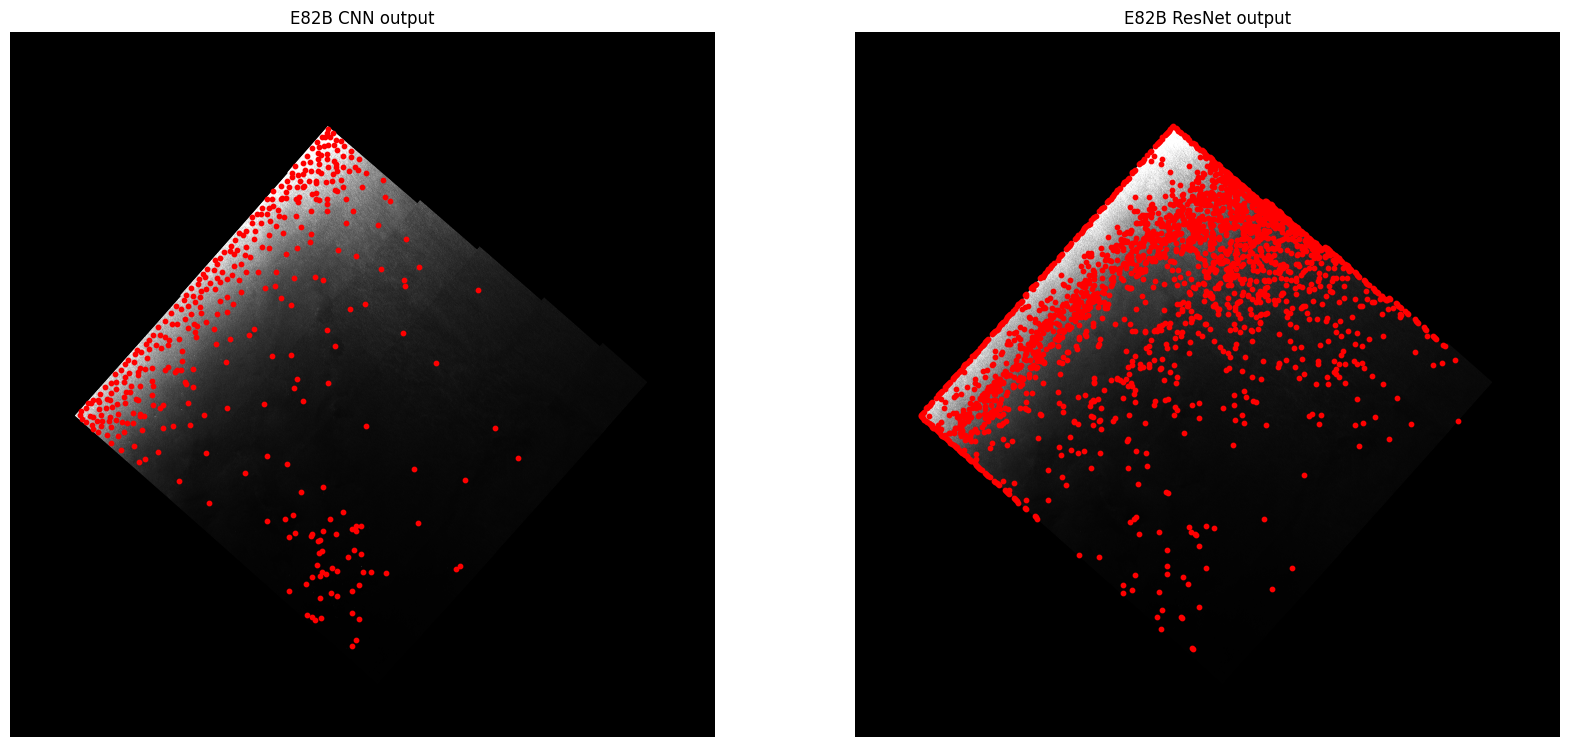

Processing A890
A890: Importing files


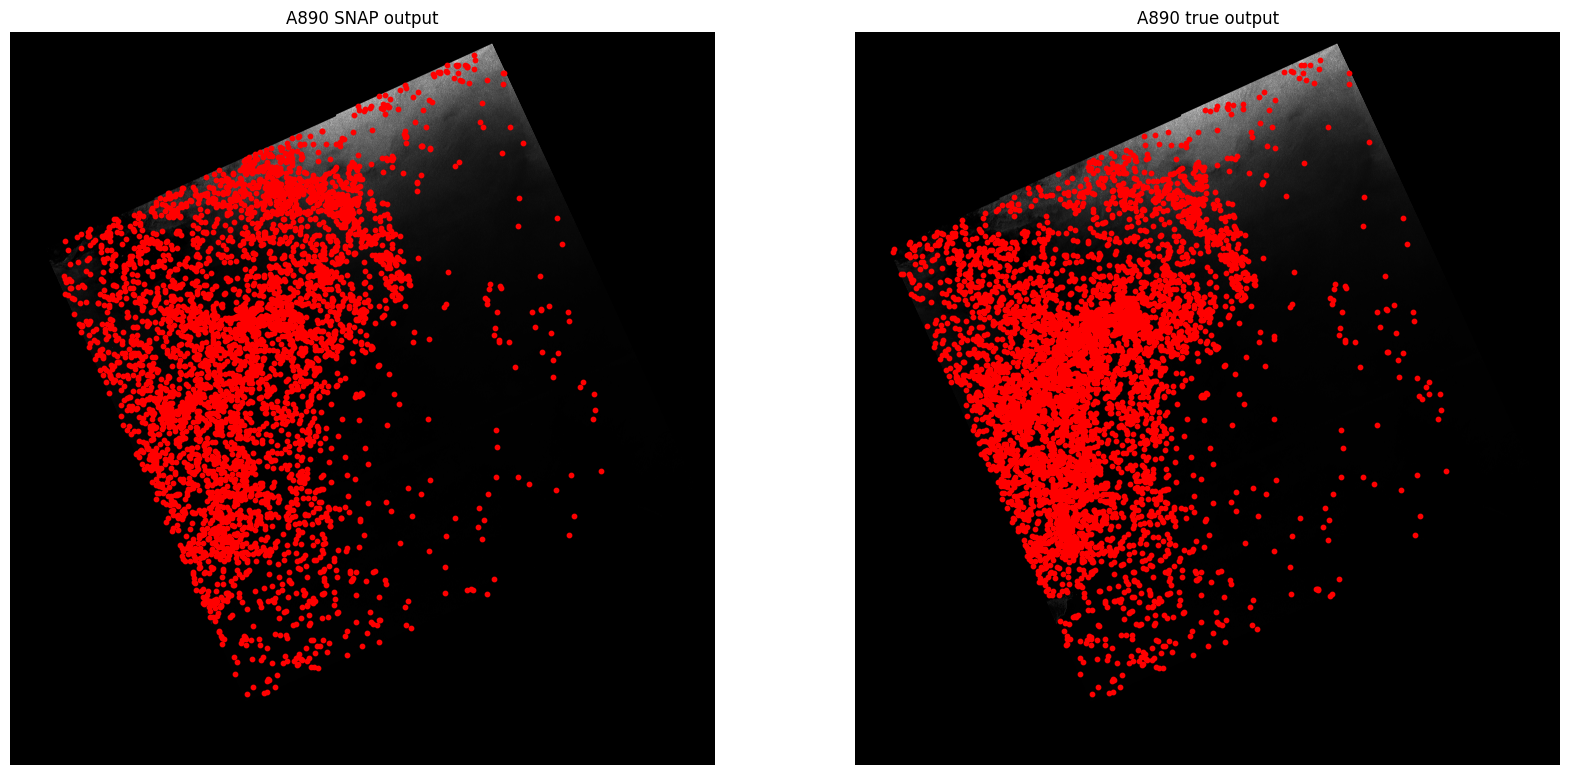

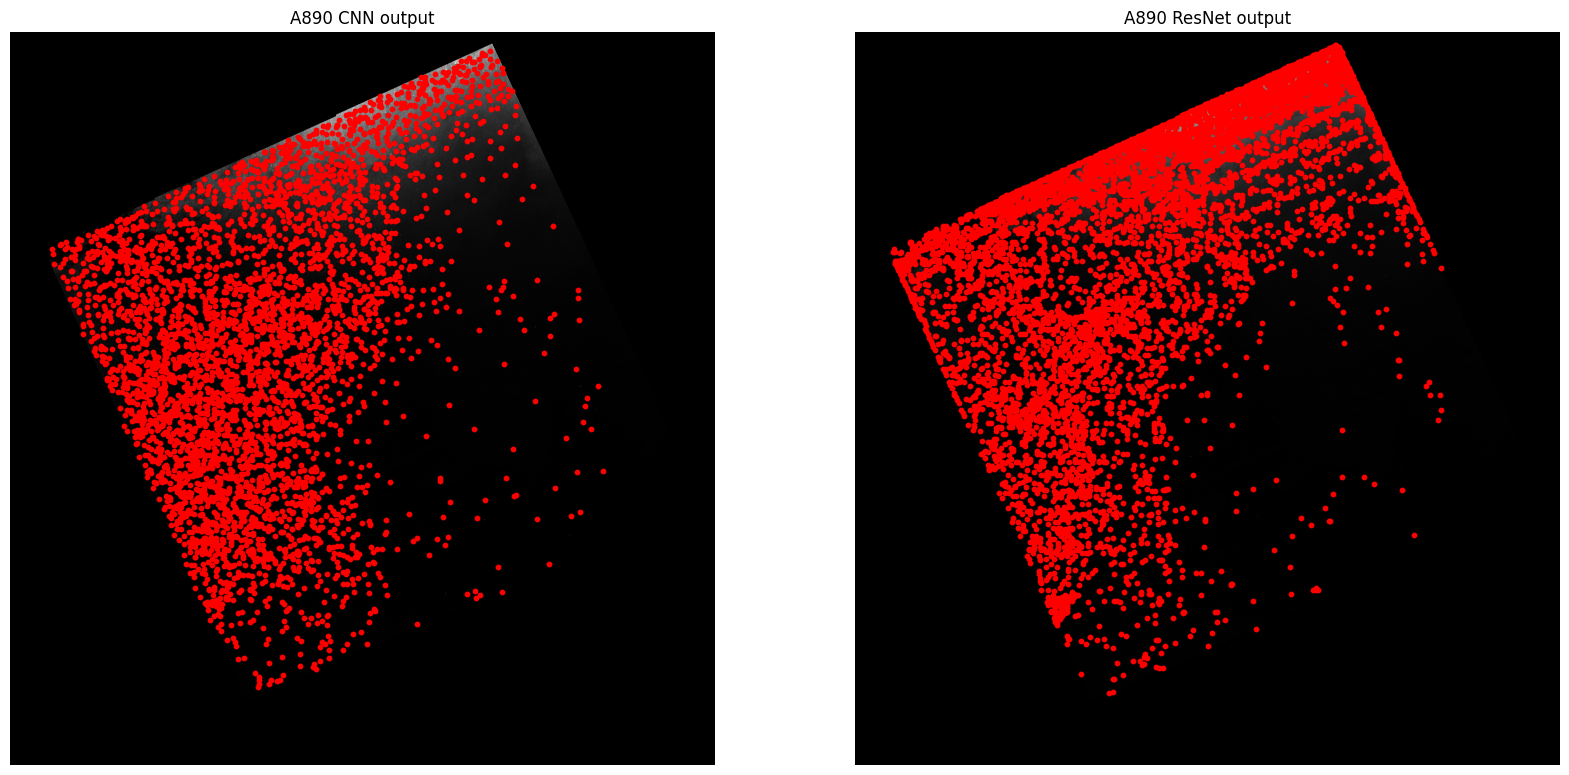

In [ ]:
# For D15B and 264D, plot all individual model predictions
import time

results = {}

for img_name in images_names:
    print(f"Processing {img_name}")

    # Get the img_name path
    filename = os.listdir(f"{images_folder}/{img_name}")[0]
    image_path = f"{images_folder}/{img_name}/{filename}"
    ds = gdal.Open(image_path, gdalconst.GA_ReadOnly)
    gt = ds.GetGeoTransform()
    img = np.asarray(ds.GetRasterBand(1).ReadAsArray())
    img = img_as_ubyte(img)

    # Get the true shapefile path
    folder_name = [folder for folder in os.listdir(f"{true_shapefiles_folder}") if folder[-4:]==img_name][0]
    true_shapefile_path = f"{true_shapefiles_folder}/{folder_name}/{folder_name}.shp"

    # Get the predicted shapefile path
    snap_shapefile_path = f"{predicted_shapefiles_folder}/SNAP_{img_name}/SNAP_{img_name}.shp"
    cnn_shapefile_path = f"{predicted_shapefiles_folder}/CNN_Nandi_shpfile/{img_name}/{img_name}.shp"
    resnet_shapefile_path = f"{predicted_shapefiles_folder}/results-Jiaxin/{img_name}/{img_name}.shp"

    print(f"{img_name}: Importing files")
    # Import all shapefiles, have a vote.
    # TODO: solve why we need 4326 for shapefiles from SNAP
    actual_x, actual_y = pointsAsPixels(true_shapefile_path, gt)
    snap_x, snap_y = pointsAsPixels4326(snap_shapefile_path, gt)  # need to use 4326 for SNAP
    cnn_x, cnn_y = pointsAsPixels(cnn_shapefile_path, gt)
    resn_x, resn_y = pointsAsPixels4326(resnet_shapefile_path, gt)

    plotImageWithPointsSideBySide(img, snap_x, snap_y, f"{img_name} SNAP output", img, actual_x, actual_y, f"{img_name} true output")
    plotImageWithPointsSideBySide(img, cnn_x, cnn_y, f"{img_name} CNN output", img, resn_x, resn_y, f"{img_name} ResNet output")

## Study effect of max_dist

In [ ]:
# Study the effect of max_dist on the ensemble model, on 06D2
results_max_dist = {}
max_dist_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150]

for img_name in ['A890']:
    results_max_dist[img_name] = {}
    for max_dist in max_dist_values:
        print(f"Processing {img_name}, max_dist = {max_dist}")

        # Get the img_name path
        filename = os.listdir(f"{images_folder}/{img_name}")[0]
        image_path = f"{images_folder}/{img_name}/{filename}"
        ds = gdal.Open(image_path, gdalconst.GA_ReadOnly)
        gt = ds.GetGeoTransform()
        img = np.asarray(ds.GetRasterBand(1).ReadAsArray())
        img = img_as_ubyte(img)

        # Get the true shapefile path
        folder_name = [folder for folder in os.listdir(f"{true_shapefiles_folder}") if folder[-4:]==img_name][0]
        true_shapefile_path = f"{true_shapefiles_folder}/{folder_name}/{folder_name}.shp"

        # Get the predicted shapefile path
        snap_shapefile_path = f"{predicted_shapefiles_folder}/SNAP_{img_name}/SNAP_{img_name}.shp"
        cnn_shapefile_path = f"{predicted_shapefiles_folder}/CNN_Nandi_shpfile/{img_name}/{img_name}.shp"
        resnet_shapefile_path = f"{predicted_shapefiles_folder}/results-Jiaxin/{img_name}/{img_name}.shp"

        # Import all shapefiles, have a vote.
        # TODO: solve why we need 4326 for shapefiles from SNAP
        actual_x, actual_y = pointsAsPixels(true_shapefile_path, gt)
        snap_x, snap_y = pointsAsPixels4326(snap_shapefile_path, gt)  # need to use 4326 for SNAP
        cnn_x, cnn_y = pointsAsPixels(cnn_shapefile_path, gt)
        resn_x, resn_y = pointsAsPixels4326(resnet_shapefile_path, gt)

        snap_coord = np.array([snap_x, snap_y])
        cnn_coord = np.array([cnn_x, cnn_y])
        resn_coord = np.array([resn_x, resn_y])

        start_time = time.time()
        votes = oneToOneMatchSequential([snap_coord, cnn_coord, resn_coord], max_dist)
        end_time = time.time()

        # Get coordinates for each vote value
        max_votes = max(votes.values())
        votes_nb = [list(filter(lambda x: x[1] == i, votes.items())) for i in range(1, max_votes+1)]
        votes_coord = [np.array([x[0] for x in votes_i]) for votes_i in votes_nb]

        # Save evaluation metrics, only consider votes 2 to 3
        votes_nb = [list(filter(lambda x: x[1] == i, votes.items())) for i in range(1, 4)]
        votes_coord = [np.array([x[0] for x in votes_i]) for votes_i in votes_nb if len(votes_i) > 0]
        votes_2_to_3 = np.concatenate(votes_coord[1:], axis=0)
        result, pred_array, actual_array = oneToOneMatch(votes_2_to_3.T, np.array([actual_x, actual_y]), max_dist)
        confusion_matrix, precision, recall, f1_score = get_and_print_evaluation_metrics(result, pred_array, actual_array, "Ensemble")
        results_max_dist[img_name][max_dist] = {"confusion_matrix": confusion_matrix, "precision": precision, "recall": recall, "f1_score": f1_score}

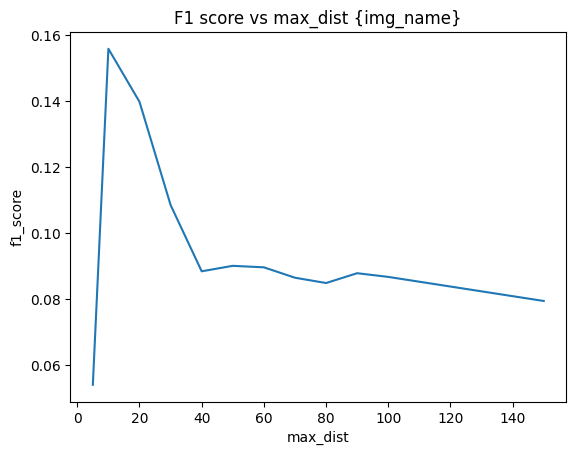

In [ ]:
# Plot the f1 scores as a function of max_dist for the images 06D2 and 17F5
for img_name in ['A890']:
    f1_scores = [results_max_dist[img_name][max_dist]["f1_score"] for max_dist in max_dist_values]
    plt.plot(max_dist_values, f1_scores)
    plt.xlabel("max_dist")
    plt.ylabel("f1_score")
    plt.title(f"F1 score vs max_dist {img_name}")
    plt.show()